<a href="https://colab.research.google.com/github/Mariamibrahim223/Chen_plasma_physics/blob/main/Proj_Ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import animation, rc
rc('animation', html='html5')
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# General Diffusion of Species

$$
\frac{\partial n}{\partial t} = D_s \nabla^2 n
$$

For:
$$
D_s = \frac{KT_s}{m_s \nu_s}, \quad s: \text{species: i or e}
$$

### Finite Difference
For $n(x_i, t^j)$

$$
\frac{\partial n}{\partial t} \approx \frac{n_i^{j+1} - n_j^i}{\Delta t}
$$

$$
\frac{\partial^2 n}{\partial x^2} \approx \frac{n_{i+1}^j - 2 n_i^j + n_{i-1}^j}{(\Delta x)^2}
$$

Hence:
$$
\frac{n_i^{j+1} - n_i^j}{\Delta t} = D_s\frac{n_{i+1}^j - 2 n_i^j + n_{i-1}^j}{(\Delta x)^2}
$$

Hence:
$$
n_i^{j+1} = n_i^j + \frac{D_s \Delta t}{(\Delta x)^2} [n_{i+1}^j - 2 n_i^j + n_{i-1}^j]
$$






In [ ]:
# Electron Parameters
KT_e = 100e3
m_e = 1.0
nu_e = 1e6
D_e = (KT_e/(m_e*nu_e))

# Ion Parameters
KT_i = 1e3
m_i = 1837
nu_i = 1e2
D_i = (KT_i/(m_i*nu_i))

Stability parameters: alpha_i = 0.0107, alpha_e = 0.1960


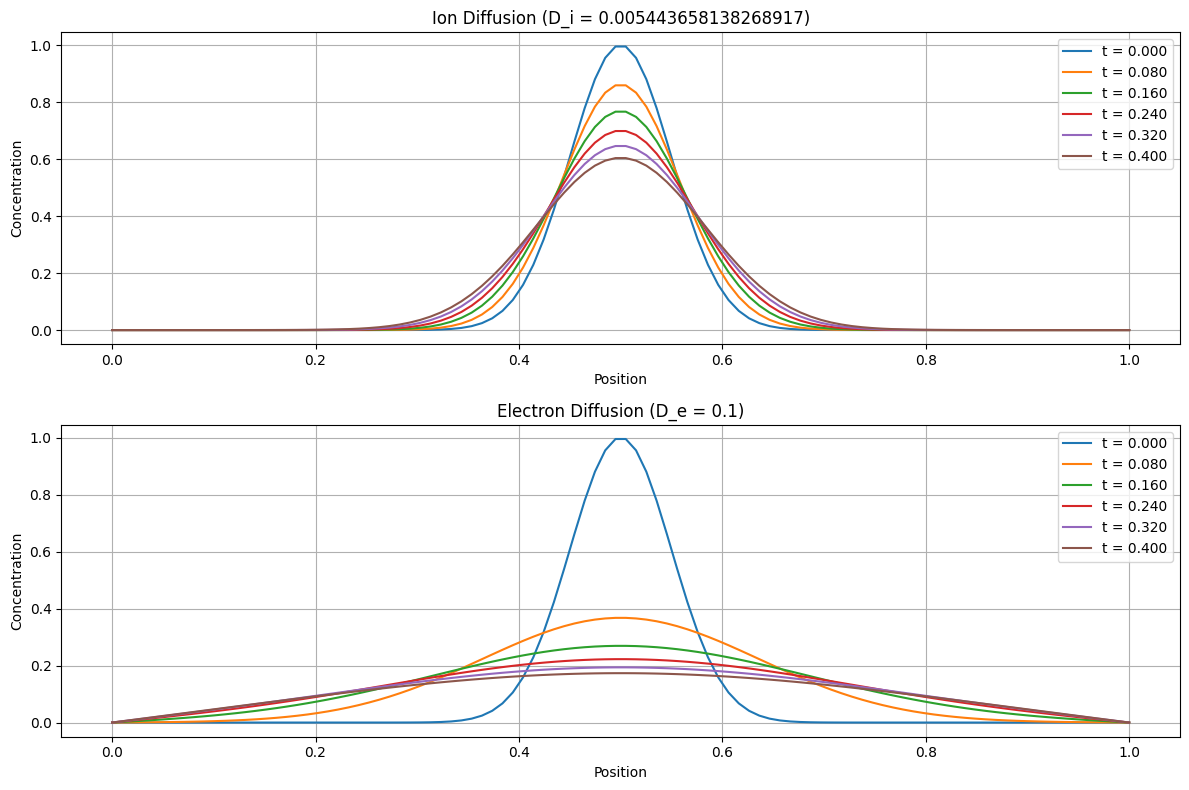

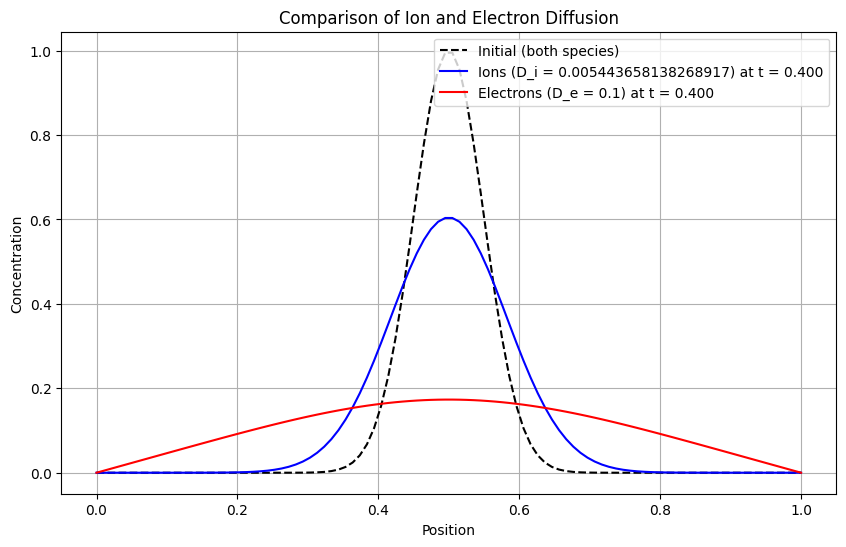

In [ ]:
# Parameters
L = 1.0     # Length of the domain
Nx = 100    # Number of spatial points
Nt = 2000   # Number of time steps
dt = 0.0002 # Reduced time step size for stability
dx = L / (Nx - 1)  # Spatial step size

# Stability conditions
alpha_i = D_i * dt / dx**2
alpha_e = D_e * dt / dx**2

if alpha_i > 0.5 or alpha_e > 0.5:
    raise ValueError(f"Unstable scheme: alpha_i = {alpha_i:.3f}, alpha_e = {alpha_e:.3f} (should be ≤ 0.5)")

print(f"Stability parameters: alpha_i = {alpha_i:.4f}, alpha_e = {alpha_e:.4f}")

# Initialize concentration arrays
ni = np.zeros(Nx)  # ions
ne = np.zeros(Nx)  # electrons
x = np.linspace(0, L, Nx)

# Initial condition (Gaussian pulse centered in the domain)
ni[:] = np.exp(-(x - L/2)**2 / 0.005)
ne[:] = np.exp(-(x - L/2)**2 / 0.005)

# Boundary conditions (Dirichlet: fixed ends)
ni[0] = 0.0
ni[-1] = 0.0
ne[0] = 0.0
ne[-1] = 0.0

# Store initial state
ni_history = [ni.copy()]
ne_history = [ne.copy()]
times = [0]

# Time-stepping loop
for t in range(1, Nt+1):
    ni_new = ni.copy()
    ne_new = ne.copy()

    # Update
    for i in range(1, Nx-1):
        ni_new[i] = ni[i] + alpha_i * (ni[i+1] - 2*ni[i] + ni[i-1])
        ne_new[i] = ne[i] + alpha_e * (ne[i+1] - 2*ne[i] + ne[i-1])

    ni = ni_new
    ne = ne_new

    # Boundary conditions
    ni[0] = 0.0
    ni[-1] = 0.0
    ne[0] = 0.0
    ne[-1] = 0.0

    # Store snapshots
    if t % (Nt // 5) == 0 or t == Nt:
        ni_history.append(ni.copy())
        ne_history.append(ne.copy())
        times.append(t * dt)

# Plotting
plt.figure(figsize=(12, 8))

# Plot ions
plt.subplot(2, 1, 1)
for i, (profile, time) in enumerate(zip(ni_history, times)):
    plt.plot(x, profile, label=f't = {time:.3f}')
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.title('Ion Diffusion (D_i = {})'.format(D_i))
plt.legend()
plt.grid(True)

# Plot electrons
plt.subplot(2, 1, 2)
for i, (profile, time) in enumerate(zip(ne_history, times)):
    plt.plot(x, profile, label=f't = {time:.3f}')
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.title('Electron Diffusion (D_e = {})'.format(D_e))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Create a combined plot to compare ions and electrons at the final time
plt.figure(figsize=(10, 6))
plt.plot(x, ni_history[0], 'k--', label='Initial (both species)')
plt.plot(x, ni_history[-1], 'b-', label=f'Ions (D_i = {D_i}) at t = {times[-1]:.3f}')
plt.plot(x, ne_history[-1], 'r-', label=f'Electrons (D_e = {D_e}) at t = {times[-1]:.3f}')
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.title('Comparison of Ion and Electron Diffusion')
plt.legend()
plt.grid(True)
plt.show()

## Ambipolar Diffusion
$$
\mathbf{\Gamma}_e = \mathbf{\Gamma}_i = \mathbf{\Gamma}, \quad \mathbf{E} = \frac{D_i - D_e}{\mu_i + \mu_e} \frac{\nabla n}{n}
$$

$$
D_a = \frac{\mu_i D_e + \mu_e D_i}{\mu_i + \mu_e}
$$

$$
\frac{\partial n}{\partial t} = D_a \nabla^2 n
$$

We will also use $E$ for velocity calculations.

$$
m \frac{\partial v}{\partial t} = q ( E + v \times B)
$$

## Setup of 1D Solution

1. Initiation of $n = n_0 + n_1$.

2. Solving:
$$
\frac{\partial n}{\partial t} = D_a \frac{\partial^2 n}{\partial x^2}
$$

$$
n_i^{j+1} = n_i^j + \frac{D_a \Delta t}{(\Delta x)^2} [n_{i+1}^j - 2 n_i^j + n_{i-1}^j]
$$

3. We have:
$$
E = \frac{D_i - D_e}{\mu_i + \mu_e} \frac{1}{n} \frac{\partial n}{\partial x}
$$

$$
E = \frac{D_i - D_e}{\mu_i + \mu_e} \frac{1}{n \Delta x}  [ n_{i+1}^j - n_i^j ]
$$

4. We solve for $v$:
$$
m \frac{\partial v}{\partial t} = q E
$$

$$
v^{j+1} = v^j + \frac{q \Delta t}{m} E_i
$$

5. We have:
$$
\frac{dr}{dt} = v
$$

$$
r^{j+1} = r^j + \Delta t v^j
$$

6. Plot evolution of $n$ through $x$ and $t$, and also the particles positions $r$ vs $t$. This is solved for both ions and electrons.




In [ ]:
q = 1.0

mu_e = (q*D_e)/(KT_e)
mu_i = (q*D_e)/(KT_i)

D_a = (mu_i*D_e + mu_e*D_i)/(mu_i + mu_e)

Stability parameter: alpha = 0.009709


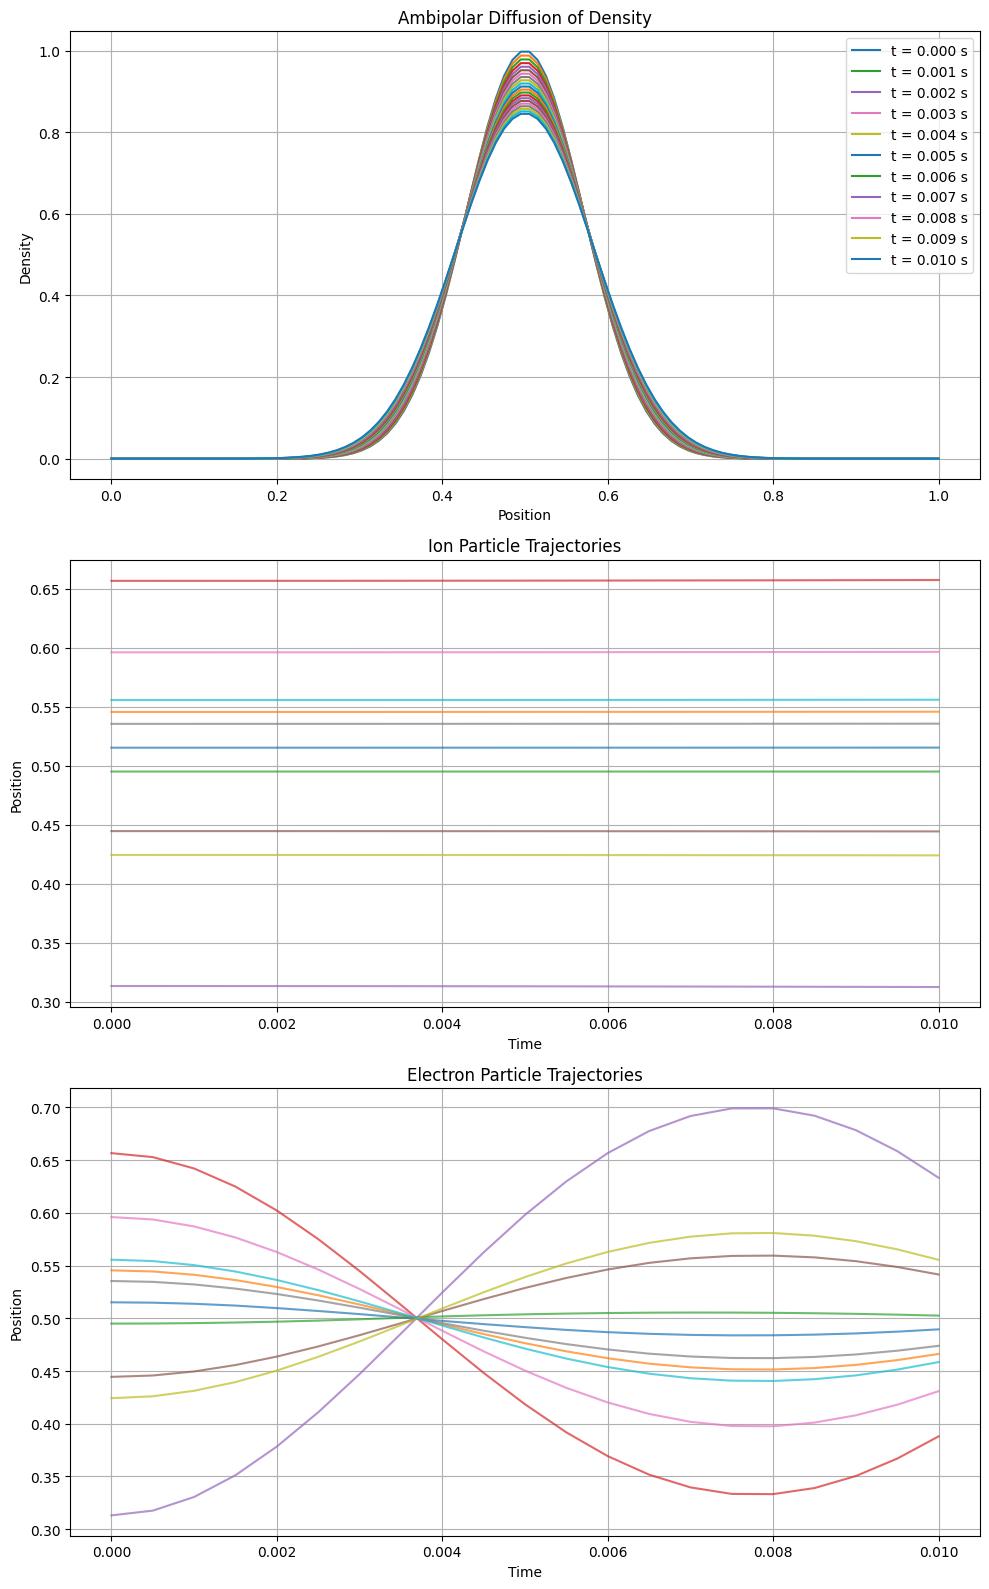

In [ ]:
# Numerical parameters
L = 1.0        # Length of the domain
Nx = 100       # Number of spatial points
Nt = 1000      # Number of time steps
dt = 1e-5      # Time step size
dx = L / (Nx - 1)  # Spatial step size

# Stability condition for ambipolar diffusion
alpha = D_a * dt / dx**2
print(f"Stability parameter: alpha = {alpha:.6f}")
if alpha > 0.5:
    raise ValueError(f"Unstable scheme: alpha = {alpha:.6f} > 0.5")

# Initialize density array
n = np.zeros(Nx)
x = np.linspace(0, L, Nx)

# Initial condition (Gaussian pulse)
center = L/2
width = 0.01
n0 = np.exp(-(x - center)**2 / width)  # Initial density
n = n0.copy()

# Boundary conditions (Dirichlet: fixed ends)
n[0] = 0.0
n[-1] = 0.0

# Initialize particle arrays
N_p = 50

# Initialize ion particles
r_i = np.zeros(N_p)
v_i = np.zeros(N_p)

for i in range(N_p):
    # Sample position according to initial density
    r_i[i] = np.random.choice(x, p=n0/n0.sum())

# Initialize electron particles (same initial positions)
r_e = r_i.copy()
v_e = np.zeros(N_p)

# Store history for visualization
n_history = [n.copy()]
ion_history = [r_i.copy()]
electron_history = [r_e.copy()]
E_history = [np.zeros(Nx)]
time_points = [0]

# Time-stepping loop
for t in range(1, Nt+1):
    # Update density using ambipolar diffusion
    n_new = n.copy()
    for i in range(1, Nx-1):
        n_new[i] = n[i] + alpha * (n[i+1] - 2*n[i] + n[i-1])

    n = n_new

    # Boundary conditions
    n[0] = 0.0
    n[-1] = 0.0

    # Calculate electric field
    E = np.zeros(Nx)
    for i in range(1, Nx-1):
        # Avoid division by zero
        if n[i] > 1e-10:
            dndx = (n[i+1] - n[i-1]) / (2*dx)  # Central difference
            E[i] = (D_i - D_e) / (mu_i + mu_e) * dndx / n[i]

    # Update particle positions and velocities
    for i in range(N_p):
        # Find the grid index closest to the particle position
        ion_idx = np.abs(x - r_i[i]).argmin()
        electron_idx = np.abs(x - r_e[i]).argmin()

        # Update velocities (F = qE, a = F/m)
        v_i[i] += (q * E[ion_idx] / m_i) * dt  # q_i = +q
        v_e[i] += (-q * E[electron_idx] / m_e) * dt  # q_e = -q

        # Update positions
        r_i[i] += v_i[i] * dt
        r_e[i] += v_e[i] * dt

        # Reflective boundary conditions for particles (separate for ions and electrons)
        if r_i[i] < 0:
            r_i[i] = -r_i[i]
            v_i[i] = -v_i[i]
        elif r_i[i] > L:
            r_i[i] = 2*L - r_i[i]
            v_i[i] = -v_i[i]

        if r_e[i] < 0:
            r_e[i] = -r_e[i]
            v_e[i] = -v_e[i]
        elif r_e[i] > L:
            r_e[i] = 2*L - r_e[i]
            v_e[i] = -v_e[i]

    # Store history at specific intervals
    if t % 50 == 0:
        n_history.append(n.copy())
        ion_history.append(r_i.copy())
        electron_history.append(r_e.copy())
        E_history.append(E.copy())
        time_points.append(t * dt)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 16))

# Plot density evolution
for i, t in enumerate(time_points):
    axes[0].plot(x, n_history[i], label=f't = {t:.3f} s' if i % 2 == 0 else "")
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Density')
axes[0].set_title('Ambipolar Diffusion of Density')
axes[0].legend()
axes[0].grid(True)

# Plot ion trajectories
for i in range(min(10, N_p)):  # Plot first 10 particles
    trajectory = [pos[i] for pos in ion_history]
    axes[1].plot(time_points[:len(trajectory)], trajectory, alpha=0.7)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Position')
axes[1].set_title('Ion Particle Trajectories')
axes[1].grid(True)

# Plot electron trajectories
for i in range(min(10, N_p)):  # Plot first 10 particles
    trajectory = [pos[i] for pos in electron_history]
    axes[2].plot(time_points[:len(trajectory)], trajectory, alpha=0.7)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Position')
axes[2].set_title('Electron Particle Trajectories')
axes[2].grid(True)

plt.tight_layout()
plt.show()